# Estimate y errors of spectra in arbitrary units

The spectra in Raman spectroscopy are obtained by CCD arrays. Each CCD pixel collects charge due to Raman-shifted photons irradiating the surface of the CCD array. The photon counting statistics leads to poissonian errors in detected photons, so in the collected charge. In counting statistics it is well known that
$$
\sigma_N=\sqrt{N}.
$$
But as we do not know the charge in ADC units that is caused by a single photon, the attribution of ucertainties of spectrum bins is not as trivial.

The idea is to enforce the knowleage for the origin of the noise in the spectra in order to convert the units on y axis to counts. This will make the previous equation applicable.

The proposed algorithm makes several assumptions:
- the values in successive bins are i.i.d.
- the noise is only due to counting statistics
- dark current is not taken into account

## Spectrum generation

In [1]:
from ramanchada2 import spectrum
from ramanchada2.spectral_components import GaussPeak, SpectralComponentCollection
import scipy.stats
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

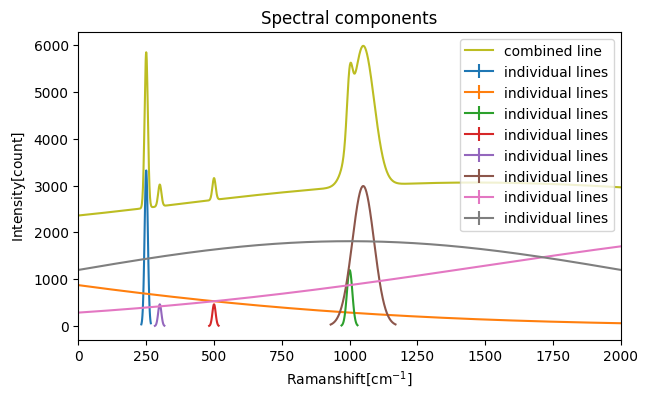

In [2]:
spe_coll = SpectralComponentCollection([
    GaussPeak(a=50000, x0=250, w=6),
    GaussPeak(a=7000, x0=300, w=6),
    GaussPeak(a=7000, x0=500, w=6),
    GaussPeak(a=30000, x0=1000, w=10),
    GaussPeak(a=300000, x0=1050, w=40),
    GaussPeak(a=8000000, x0=3000, w=1500),
    GaussPeak(a=5000000, x0=1000, w=1100),
    GaussPeak(a=8000000, x0=-2000, w=1500),
])
fig, ax = plt.subplots(1, figsize=(7, 4))
spe_coll.plot(ax=ax, draw='individual lines', label='individual lines')
spe_coll.plot(ax=ax, draw='combined line', label='combined line')
ax.set_xlim(0, 2000)
ax.set_title('Spectral components')
ax.set_xlabel('$\mathrm{Raman shift [cm^{-1}]}$')
_ = ax.set_ylabel('$\mathrm{Intensity [count]}$')

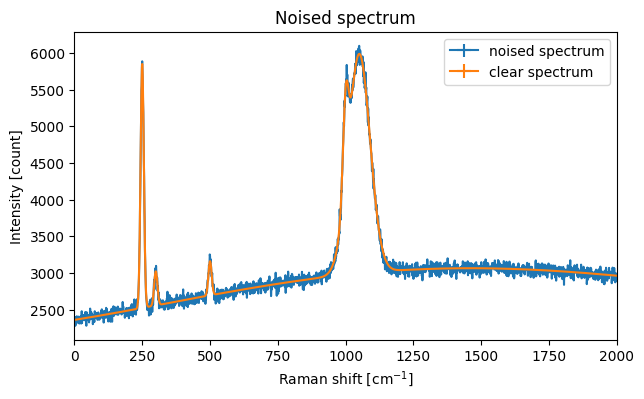

In [3]:
spe_clear = spectrum.from_spectral_component_collection(x=2000, spe_components=spe_coll)
spe_noise = spe_clear.add_poisson_noise()
fig, ax = plt.subplots(1, figsize=(7, 4))
spe_noise.plot(ax=ax, label='noised spectrum')
spe_clear.plot(ax=ax, label='clear spectrum')
ax.set_xlim(0, 2000)
ax.set_title('Noised spectrum')
ax.set_xlabel('Raman shift $\mathrm{[cm^{-1}]}$')
_ = ax.set_ylabel('Intensity [count]')

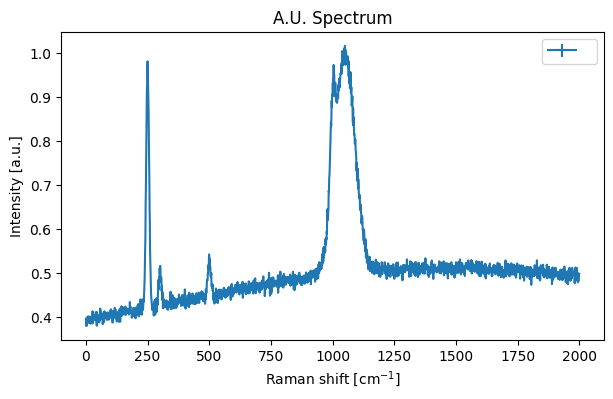

In [4]:
spe_au = spe_noise.scale_yaxis_linear(factor=1/6000)
fig, ax = plt.subplots(1, figsize=(7, 4))
spe_au.plot(ax=ax)
ax.set_title('A.U. Spectrum')
ax.set_xlabel('Raman shift $\mathrm{[cm^{-1}]}$')
_ = ax.set_ylabel('Intensity [a.u.]')

## Exclude peak areas

Near peak regions assumption for i.i.d. is not relevant, so peak regions need to be excluded from calculations. A way to do so is to check for asymetry of distributions in a moving rectangular window.
$$
\left|\frac{\mathrm{mean}(dat)-\mathrm{median}(dat)}{\mathrm{mean}(dat)}\right|
$$

In [5]:
def peak_filter_moving_window(dat, window_size, threshold=1e-2):
    asym = list()
    for i in range(window_size//2, len(dat)-window_size//2):
        sub_arr = dat[int(i-window_size//2):int(i+window_size//2)]
        asym.append((np.mean(sub_arr) - np.median(sub_arr))/np.mean(sub_arr))
    asym = np.abs(np.array(asym))
    is_peak = np.empty_like(dat, dtype=bool)
    for i in range(len(dat)):
        if (asym[i-window_size:i] > threshold).any():
            is_peak[i] = True
        else:
            is_peak[i] = False
    return is_peak, asym


In [6]:
sss = spe_au
is_peak, asym = peak_filter_moving_window(sss.y, 50)

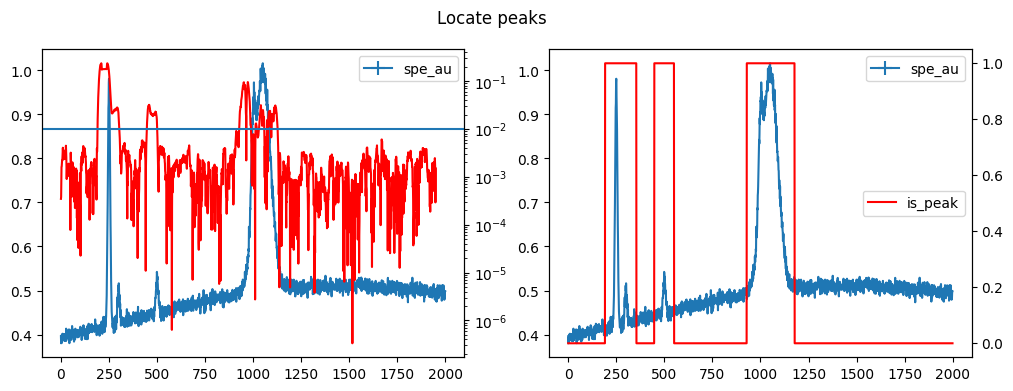

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sss.plot(ax=ax[0], label='spe_au')
ax01 = ax[0].twinx()
ax01.plot(asym, 'r', label='is_peak')
ax01.set_yscale('log')
ax01.axhline(1e-2)

sss.plot(ax=ax[1], label='spe_au')
ax11 = ax[1].twinx()
ax11.plot(is_peak, 'r', label='is_peak')
ax11.legend(loc='center right')
_ = fig.suptitle('Locate peaks')

## Coefficient of proportionality (scaling factor)

Assuming that successive bins in spectrum are i.i.d. gaussian, their differences will follow a gaussian distribution, wider with factor $\sqrt{2}$. Taking absolute value of the gassian will lead to additional broadingng by factor of $\sqrt{2}$. Widths of difference spectrum should be similar for similar amplitudes.

In [8]:
noise_only = np.array(spe_au.y[~is_peak], dtype=float)
diff_noise_only = np.abs(np.diff(noise_only))
noise_only_mean = (noise_only[1:] + noise_only[:-1])/2
x, y = diff_noise_only, np.sqrt(noise_only_mean)
slope = 2*np.sum(x*y)/np.sum(x*x)

In [9]:
def merit(par, *args):
    a = par[0]
    x = args[0]
    y = args[1]
    return np.abs(2*sum(a*x > y) - len(x))
res = scipy.optimize.basinhopping(merit, [slope], stepsize=slope, minimizer_kwargs=dict(args=(x, y)))

In [10]:
def meritX(par, *args):
    a = par[0]
    x = args[0]
    y = args[1]
    return np.abs(4*.53*sum(a*x > y) - len(x))
res53 = scipy.optimize.basinhopping(meritX, [slope], stepsize=slope, minimizer_kwargs=dict(args=(x, y)))

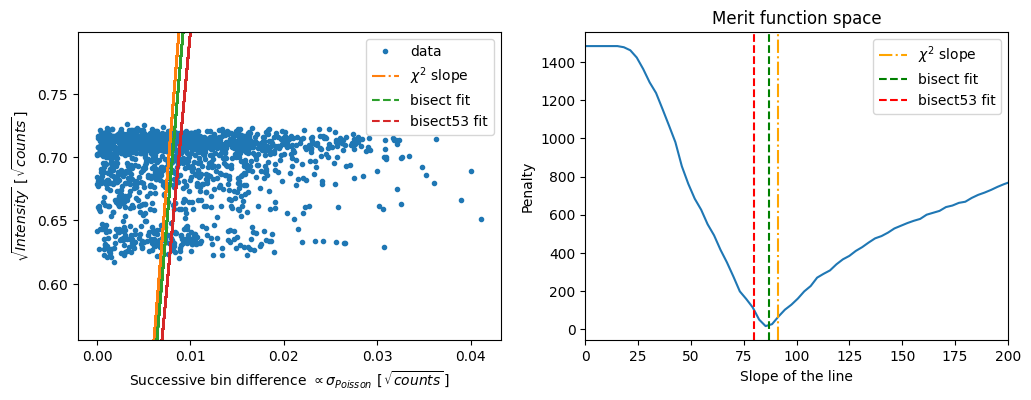

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(x, y, '.', label='data')
ax[0].plot(x, x*slope, linestyle='-.', label='$\chi^2$ slope')
ax[0].plot(x, x*res.x, linestyle='--', label='bisect fit')
ax[0].plot(x, x*res53.x, linestyle='--', label='bisect53 fit')
ax[0].set_ylim(min(y)*.9, max(y)*1.1)
ax[0].set_xlabel(r'Successive bin difference $\propto \sigma_{Poisson}~\left[\,\sqrt{counts}\,\right]$')
ax[0].set_ylabel(r'$\sqrt{Intensity}~\left[\,\sqrt{counts}\,\right]$')
ax[0].legend()

cc = np.linspace(0, slope*10, 300)
mm = [merit([i], x, y) for i in cc]
ax[1].plot(cc, mm)
ax[1].axvline(slope, linestyle='-.', label='$\chi^2$ slope', color='orange')
ax[1].axvline(res.x, linestyle='--', label='bisect fit', color='green')
ax[1].axvline(res53.x, linestyle='--', label='bisect53 fit', color='red')
ax[1].set_xlim(0, 200)

ax[1].set_xlabel('Slope of the line')
ax[1].set_ylabel('Penalty')
ax[1].set_title('Merit function space')
_ = ax[1].legend()

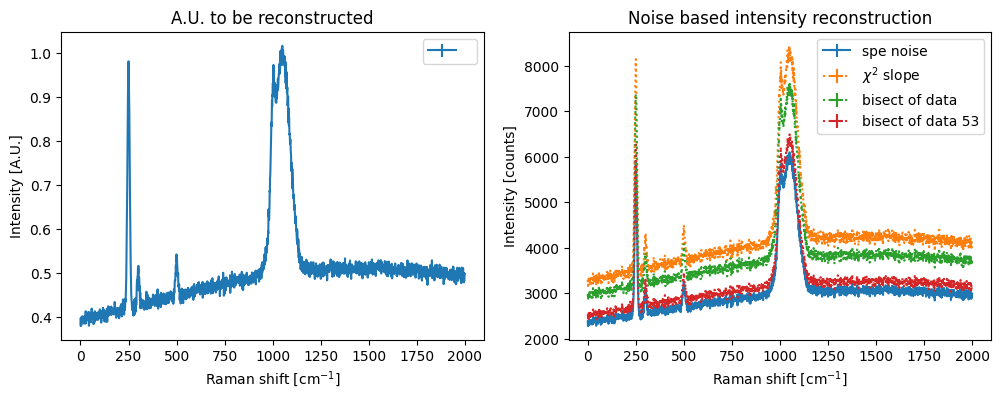

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
spe_au.plot(ax=ax[0])
ax[0].set_title('A.U. to be reconstructed')
ax[0].set_xlabel('Raman shift $\mathrm{[cm^{-1}]}$')
ax[0].set_ylabel('Intensity [A.U.]')

spe_noise.plot(ax=ax[1], label='spe noise')
spe_au.scale_yaxis_linear(factor=(slope)**2).plot(ax=ax[1], fmt=':', label='$\chi^2$ slope')
spe_au.scale_yaxis_linear(factor=(res.x)**2).plot(ax=ax[1], fmt=':', label='bisect of data')
spe_au.scale_yaxis_linear(factor=(res53.x)**2).plot(ax=ax[1], fmt=':', label='bisect of data 53')
ax[1].set_xlabel('Raman shift $\mathrm{[cm^{-1}]}$')
ax[1].set_ylabel('Intensity [counts]')
_ = ax[1].set_title('Noise based intensity reconstruction')

In [13]:
coef = list()
for i in range(30):
    spe_noise = spe_clear.add_poisson_noise()
    spe_au = spe_noise.scale_yaxis_linear(factor=1/6000)
    is_peak, asym = peak_filter_moving_window(spe_au.y, 50)
    noise_only = np.array(spe_au.y[~is_peak], dtype=float)
    diff_noise_only = np.abs(np.diff(noise_only))
    noise_only_mean = (noise_only[1:] + noise_only[:-1])/2
    x, y = diff_noise_only, np.sqrt(noise_only_mean)
    slope = 2*np.sum(x*y)/np.sum(x*x)
    res = scipy.optimize.basinhopping(meritX, [slope], stepsize=slope, minimizer_kwargs=dict(args=(x, y)))
    coef.append(res.x[0]**2)

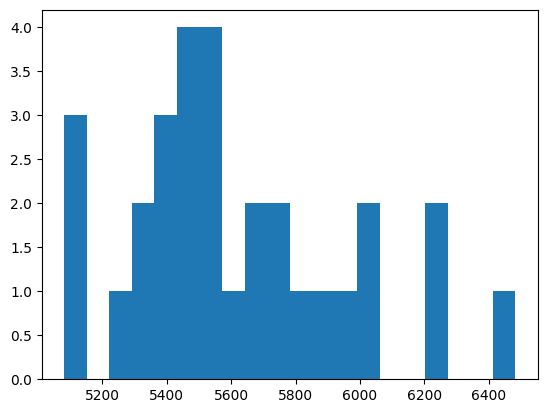

In [14]:
plt.hist(coef, bins=20)
None

In [15]:
np.mean(coef), np.std(coef)

(np.float64(5616.668638261703), np.float64(344.7558902386438))